In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import warnings

# ==============================================================================
# USER-DEFINED PARAMETERS - EDIT THESE
# ==============================================================================
# Replace with the path to your testing data file
csv_filepath = r'data\CartPole-v0\estimator_nameensemble.GradientBoostingClassifier\42\testing_data.csv'
# The specific simulation number to analyze (from 0 to 99)
simulation_number_to_analyze = 50

# ==============================================================================
# SCRIPT LOGIC - DO NOT MODIFY BELOW THIS LINE
# ==============================================================================
warnings.filterwarnings('ignore', category=UserWarning)

# Check if file exists first
if not os.path.exists(csv_filepath):
    raise FileNotFoundError(
        f"Error: The file '{csv_filepath}' was not found.\n"
        f"Current working directory: {os.getcwd()}"
    )

# Load the dataset
df = pd.read_csv(csv_filepath)

# Filter for the specified simulation number
sim_df = df[df['simulation_number'] == simulation_number_to_analyze].copy()

if sim_df.empty:
    raise ValueError(
        f"Error: No data found for simulation number {simulation_number_to_analyze}. "
        f"Please check if this simulation number exists in '{csv_filepath}'."
    )

if len(sim_df) < 50:
    raise RuntimeError(
        f"Warning: Simulation {simulation_number_to_analyze} is too short "
        f"({len(sim_df)} rows) to analyze in three segments. Skipping analysis."
    )

In [42]:
# Rename the columns for better interpretability
sim_df = sim_df.rename(columns={
        "state_0": "x",       # cart position
        "state_1": "ẋ",      # cart velocity
        "state_2": "θ",       # pole angle
        "state_3": "θ*",      # pole angular velocity
        "desired_horizon": "dh",
        "desired_return": "dr"
})

In [43]:
sim_df.tail()

,x,ẋ,θ,θ*,dr,dh,simulation_number,timestamp,action
9970,-1.784050,-1.680329,-0.030381,1.214079,0.10,-195.40,50,1.758126e+09,1
9971,-1.817657,-1.484828,-0.006099,0.912033,0.08,-195.42,50,1.758126e+09,1
9972,-1.847353,-1.289624,0.012141,0.617439,0.06,-195.44,50,1.758126e+09,1
9973,-1.873146,-1.094674,0.024490,0.328605,0.04,-195.46,50,1.758126e+09,1
9974,-1.895039,-0.899909,0.031062,0.043744,0.02,-195.48,50,1.758126e+09,1


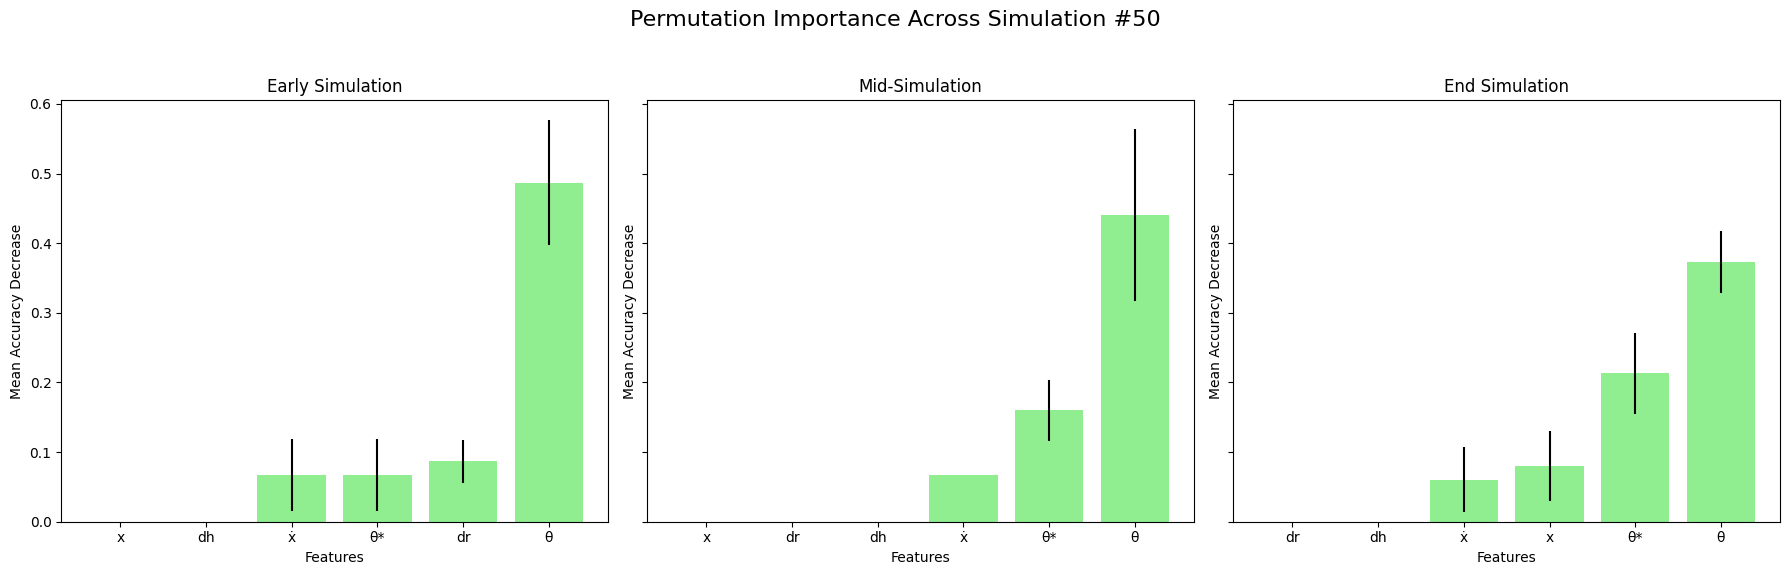

In [44]:
# Define features and target based on the renamed columns
features = [
    "x",
    "ẋ",
    "θ",
    "θ*",
    "dr",
    "dh"
]
target = 'action'

import pickle
from sklearn.inspection import permutation_importance

# Load model
with open(r"data/CartPole-v0/estimator_nameensemble.GradientBoostingClassifier/42/policy.pkl", "rb") as f:
    model = pickle.load(f)

# Define the segments (first 15, middle 15, last 15)
total_entries = len(sim_df)
segments = {
    'Early Simulation': sim_df.iloc[:15],
    'Mid-Simulation': sim_df.iloc[total_entries // 2 - 7: total_entries // 2 + 8],
    'End Simulation': sim_df.iloc[-15:]
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle(f'Permutation Importance Across Simulation #{simulation_number_to_analyze}', fontsize=16)

for ax, (title, segment_df) in zip(axes, segments.items()):
    if segment_df.empty:
        continue

    X_segment = segment_df[features]
    y_segment = segment_df[target]
    
    # Calculate permutation importance on the segment's data
    result = permutation_importance(model.estimator, X_segment, y_segment, n_repeats=10, random_state=42)
    
    # Sort features by importance and plot
    sorted_idx = result.importances_mean.argsort()
    
    ax.bar(X_segment.columns[sorted_idx], 
       result.importances_mean[sorted_idx],
       yerr=result.importances_std[sorted_idx], 
       color='lightgreen')

    ax.set_ylabel('Mean Accuracy Decrease')
    ax.set_xlabel('Features')

    
    ax.set_title(title)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


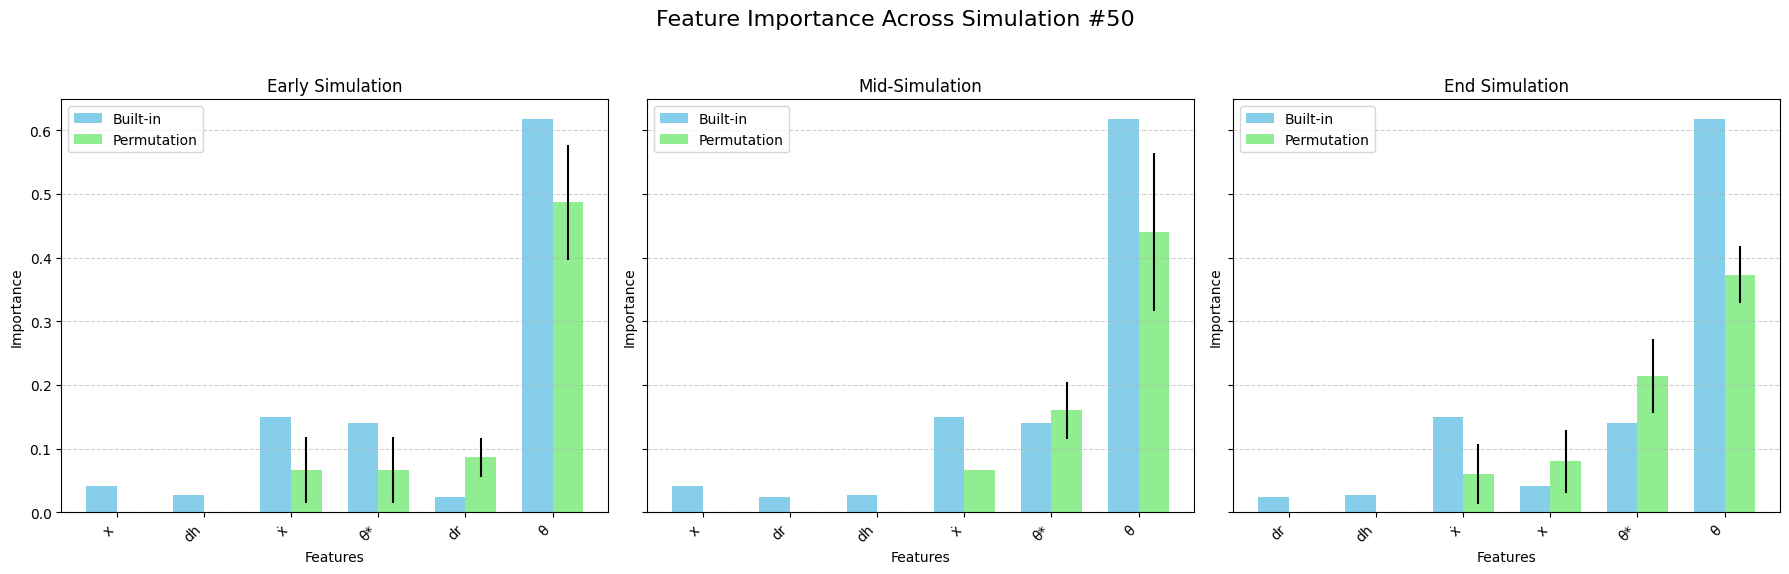

In [45]:
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle(f'Feature Importance Across Simulation #{simulation_number_to_analyze}', fontsize=16)

for ax, (title, segment_df) in zip(axes, segments.items()):
    if segment_df.empty:
        continue

    X_segment = segment_df[features]
    y_segment = segment_df[target]

    # Built-in feature importance (from the trained model)
    builtin_importance = model.estimator.feature_importances_

    # Permutation importance
    result = permutation_importance(
        model.estimator, X_segment, y_segment, 
        n_repeats=10, random_state=42
    )
    perm_importance = result.importances_mean
    perm_std = result.importances_std

    # Sort by permutation importance (or you could use builtin)
    sorted_idx = perm_importance.argsort()
    feature_names = X_segment.columns[sorted_idx]

    # Width offset for side-by-side bars
    x = np.arange(len(feature_names))
    width = 0.35  

    # Plot built-in importance
    ax.bar(x - width/2, builtin_importance[sorted_idx], width, 
           label="Built-in", color="skyblue")

    # Plot permutation importance
    ax.bar(x + width/2, perm_importance[sorted_idx], width, 
           yerr=perm_std[sorted_idx], 
           label="Permutation", color="lightgreen")

    ax.set_title(title)
    ax.set_xlabel("Features")
    ax.set_ylabel("Importance")
    ax.set_xticks(x)
    ax.set_xticklabels(feature_names, rotation=45, ha="right")
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


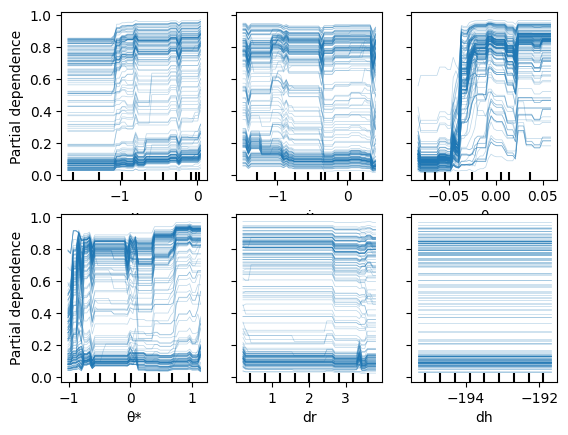

In [50]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    model.estimator, 
    sim_df[features], 
    features,  # pick 1D or 2D feature(s)
    grid_resolution=50,
    kind="individual"
)
plt.show()


In [54]:
import os
import pandas as pd
import numpy as np
import torch
import shap
import warnings

# =========================================================
# 1. Load simulation data
# =========================================================
simulation_number_to_analyze = 8
csv_filepath = r'./data/CartPole-v0/estimator_nameneural/42/testing_data.csv'

if not os.path.exists(csv_filepath):
    raise FileNotFoundError(f"File not found: {csv_filepath}")

df = pd.read_csv(csv_filepath)
sim_df = df[df['simulation_number'] == simulation_number_to_analyze].copy()

if sim_df.empty:
    raise ValueError(f"No data found for simulation #{simulation_number_to_analyze}")

if len(sim_df) < 50:
    raise RuntimeError(f"Simulation #{simulation_number_to_analyze} too short: {len(sim_df)} rows")

In [58]:
# Rename columns
sim_df = sim_df.rename(columns={
    "state_0": "x",      
    "state_1": "ẋ",      
    "state_2": "θ",      
    "state_3": "θ*",     
    "desired_horizon": "dh",
    "desired_return": "dr"
})

# =========================================================
# 2. Prepare inputs for NN
# =========================================================
state_cols = ["x", "ẋ", "θ", "θ*", "dr", "dh"]   # 6 state features
command_cols = ["action", "timestamp"]           # assuming you have 2 "command" cols (adjust if different)

X_state = sim_df[state_cols].values
X_command = sim_df[command_cols].values

# =========================================================
# 3. Define segmentation (early, mid, late)
# =========================================================
total_entries = len(sim_df)
segments = {
    'Early Simulation': slice(0, 15),
    'Mid-Simulation': slice(total_entries // 2 - 7, total_entries // 2 + 8),
    'End Simulation': slice(-15, None)
}

In [63]:
from udrl.policies import SklearnPolicy, NeuralPolicy # <-- adjust import path

policy = NeuralPolicy.load(r"data\CartPole-v0\estimator_nameneural\42\policy")
model = policy.estimator
model.eval()



# =========================================================
# 4. Define prediction function for SHAP
# =========================================================
def predict_fn(inputs: np.ndarray):
    """
    inputs shape: (batch_size, 8) → first 6 = state, last 2 = command
    """
    state = torch.tensor(inputs[:, :4], dtype=torch.float32)
    command = torch.tensor(inputs[:, 4:6], dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        probs = model(state, command).numpy()
    return probs

e:\liege\upside_down_rl\udrl\policies.py:355: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_dict = torch.load(path + ".pth")



=== Early Simulation ===


100%|██████████| 15/15 [00:00<00:00, 42.40it/s]


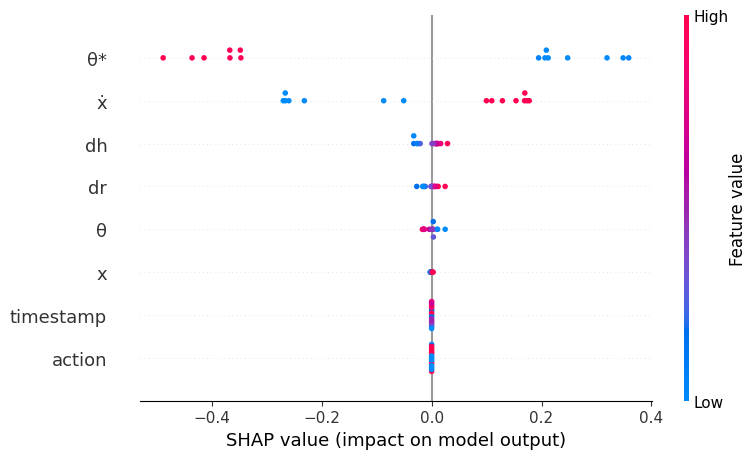

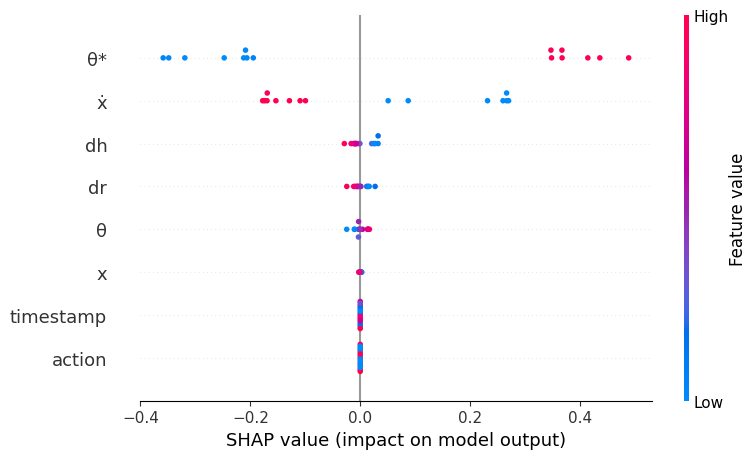


=== Mid-Simulation ===


100%|██████████| 15/15 [00:00<00:00, 97.05it/s]


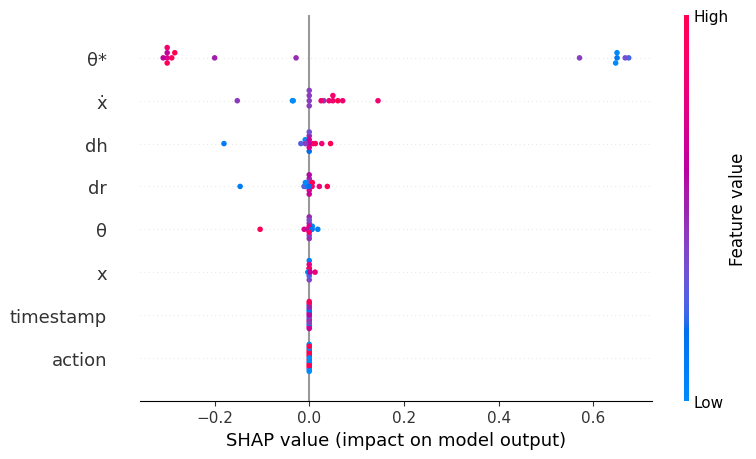

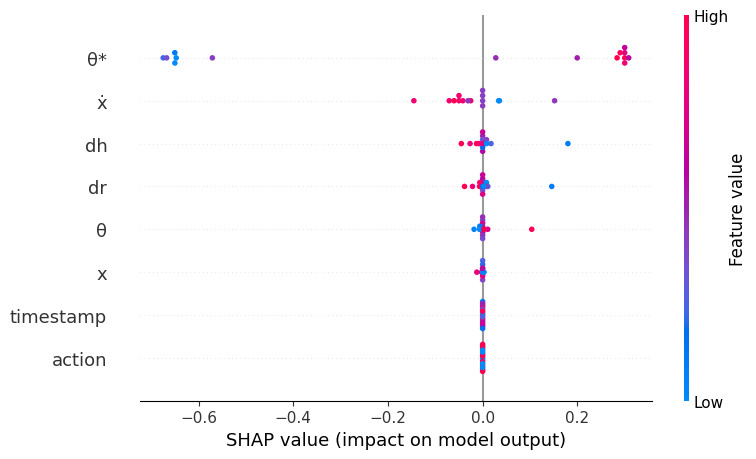


=== End Simulation ===


100%|██████████| 15/15 [00:00<00:00, 100.17it/s]


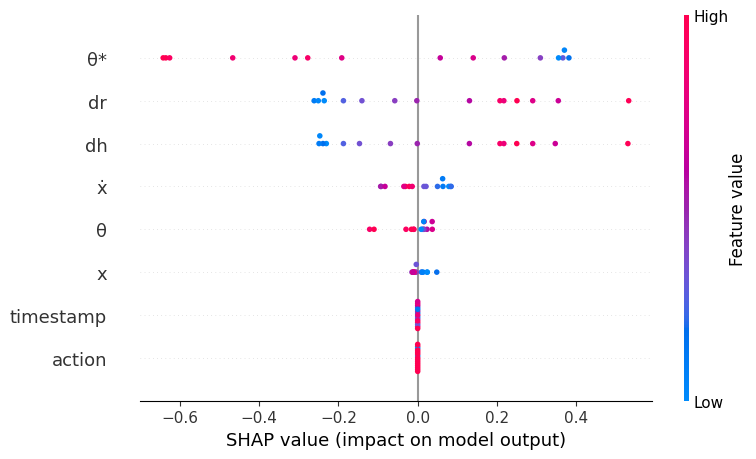

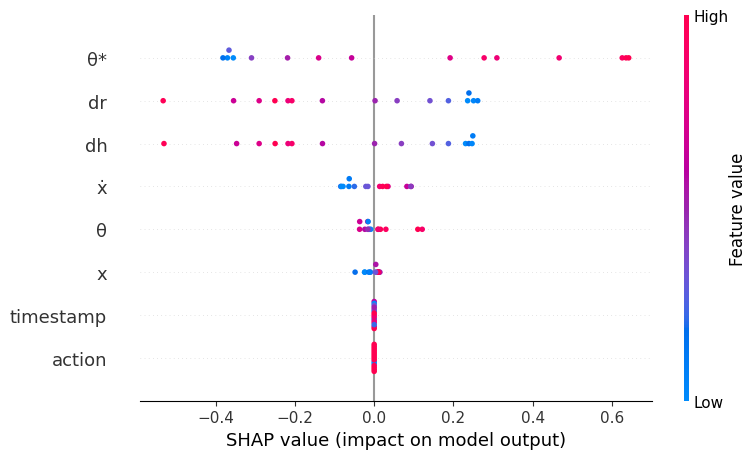

In [64]:

# =========================================================
# 5. SHAP analysis per segment
# =========================================================
for seg_name, seg_slice in segments.items():
    print(f"\n=== {seg_name} ===")

    X_state_seg = X_state[seg_slice]
    X_command_seg = X_command[seg_slice]
    X_combined_seg = np.hstack([X_state_seg, X_command_seg])

    # Background (small random subset)
    background = X_combined_seg[np.random.choice(len(X_combined_seg), min(10, len(X_combined_seg)), replace=False)]

    explainer = shap.KernelExplainer(predict_fn, background)
    shap_values = explainer.shap_values(X_combined_seg)

    # Rearrange: (class, samples, features)
    shap_values = np.transpose(shap_values, (2, 0, 1))

    for class_idx in range(len(shap_values)):
        shap.summary_plot(
            shap_values[class_idx],
            X_combined_seg,
            feature_names=state_cols + command_cols,
            show=True
        )


In [69]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from lime import lime_tabular
import warnings

# =========================================================
# 1️⃣ Load simulation data
# =========================================================
simulation_number_to_analyze = 8
csv_filepath = r'./data/CartPole-v0/estimator_nameneural/42/testing_data.csv'

if not os.path.exists(csv_filepath):
    raise FileNotFoundError(f"File not found: {csv_filepath}")

df = pd.read_csv(csv_filepath)
sim_df = df[df['simulation_number'] == simulation_number_to_analyze].copy()

if sim_df.empty:
    raise ValueError(f"No data found for simulation #{simulation_number_to_analyze}")

if len(sim_df) < 50:
    raise RuntimeError(f"Simulation #{simulation_number_to_analyze} too short: {len(sim_df)} rows")

# Rename columns for NN
sim_df = sim_df.rename(columns={
    "state_0": "x",
    "state_1": "ẋ",
    "state_2": "θ",
    "state_3": "θ*",
    "desired_horizon": "dh",
    "desired_return": "dr"
})

# =========================================================
# 2️⃣ Prepare NN inputs
# =========================================================
state_cols = ["x", "ẋ", "θ", "θ*", "dr", "dh"]   # 6 state features
command_cols = ["action", "timestamp"]           # 2 command features

X_state = sim_df[state_cols].values
X_command = sim_df[command_cols].values
X_combined = np.hstack([X_state, X_command])  # shape (n_samples, 8)


In [71]:
from udrl.policies import SklearnPolicy, NeuralPolicy # <-- adjust import path

policy = NeuralPolicy.load(r"data\CartPole-v0\estimator_nameneural\42\policy")
nn_model = policy.estimator
nn_model.eval()

e:\liege\upside_down_rl\udrl\policies.py:355: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_dict = torch.load(path + ".pth")


BehaviorNet(
  (state_entry): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (command_entry): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (model): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
    (7): Softmax(dim=-1)
  )
)


=== Segment: Early ===
Predicted class: 0  probs: [1.000000e+00 7.764273e-17]
Feature weights for class 0
-0.10 < θ* <= 0.03: 0.2326
dh > -0.91: 0.1657
-0.04 < ẋ <= 0.15: -0.1464
θ <= 0.02: 0.1322


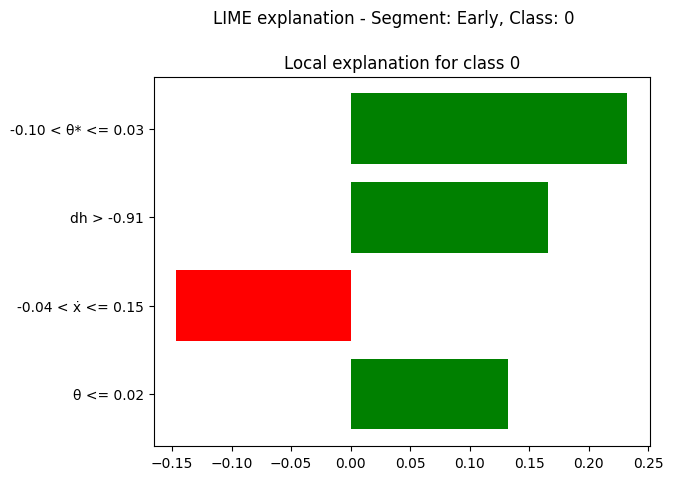


=== Segment: Mid ===
Predicted class: 1  probs: [0. 1.]
Feature weights for class 1
θ* > 0.24: 0.5667
ẋ <= -0.04: 0.1997
-1.35 < dh <= -0.91: -0.0706
0.08 < θ <= 0.11: 0.0538


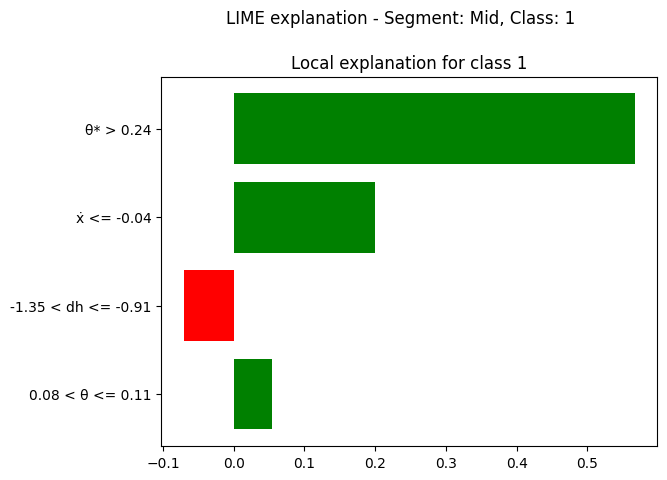


=== Segment: End ===
Predicted class: 1  probs: [4.181635e-11 1.000000e+00]
Feature weights for class 1
θ* <= -0.10: -0.4593
ẋ > 0.68: -0.3102
dh <= -1.79: 0.2058
dr <= 2.67: 0.1690


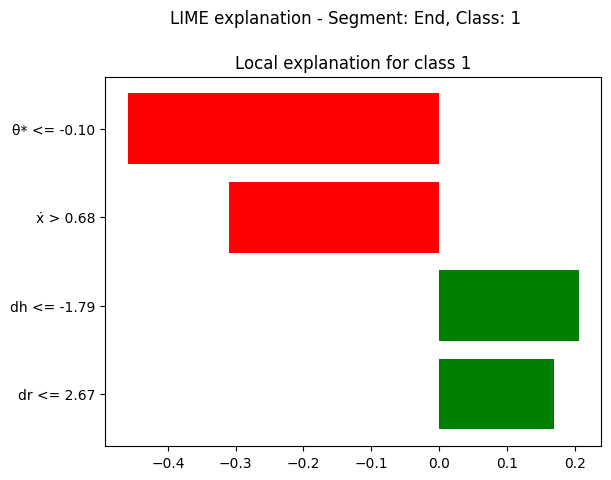

In [73]:

# =========================================================
# 3️⃣ Define segments
# =========================================================
total_entries = len(sim_df)
segments = {
    "Early": slice(0, 15),
    "Mid": slice(total_entries // 2 - 7, total_entries // 2 + 8),
    "End": slice(-15, None)
}

# =========================================================
# 4️⃣ Define prediction function for LIME
# =========================================================
def predict_fn(inputs: np.ndarray):
    """
    inputs: numpy array (n_samples, 8)
    returns: numpy array (n_samples, 3) probabilities
    """
    state = torch.tensor(inputs[:, :4], dtype=torch.float32)
    command = torch.tensor(inputs[:, 4:6], dtype=torch.float32)

    nn_model.eval()  # ensure your BehaviorNet is assigned to nn_model
    with torch.no_grad():
        probs = nn_model(state, command).numpy()  # if Softmax is already applied in NN
    return probs

# =========================================================
# 5️⃣ Create LIME explainer
# =========================================================
feature_names = state_cols + command_cols
class_names = [str(i) for i in range(3)]  # 3 classes for CartPole

explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_combined,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True
)

# =========================================================
# 6️⃣ Run LIME per segment and plot
# =========================================================
for seg_name, seg_slice in segments.items():
    print(f"\n=== Segment: {seg_name} ===")
    X_seg = X_combined[seg_slice]

    # Explain first sample in this segment
    sample_idx = 0
    sample = X_seg[sample_idx]

    exp = explainer.explain_instance(
        data_row=sample,
        predict_fn=predict_fn,
        num_features=4,  # top features to display
        top_labels=2,    # explain top 2 predicted classes
        num_samples=2000 # reduce for speed
    )

    # Predicted class for this sample
    pred_probs = predict_fn(sample.reshape(1, -1))[0]
    pred_class = int(np.argmax(pred_probs))
    print("Predicted class:", pred_class, " probs:", pred_probs)

    # Print LIME explanation as list
    print("Feature weights for class", pred_class)
    for feat, weight in exp.as_list(label=pred_class):
        print(f"{feat}: {weight:.4f}")

    # Plot bar chart
    fig = exp.as_pyplot_figure(label=pred_class)
    plt.suptitle(f"LIME explanation - Segment: {seg_name}, Class: {pred_class}", y=1.02)
    plt.show()
